# Final week capstone - Neighborhood of two cities.

# import libraries 

In [3]:
#!pip install geocoder 
import sys
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
import urllib.request
from pandas.io.html import read_html
import requests
from bs4 import BeautifulSoup
import re
import json


# Identifying source data 

In [4]:
## URL to extract City neighbourhood information
urlL = "https://en.wikipedia.org/wiki/List_of_London_boroughs"
urlP = "https://en.wikipedia.org/wiki/Arrondissements_of_Paris"
pageLondon = urllib.request.urlopen(urlL)
pageParis = urllib.request.urlopen(urlP)
wikitablesL = read_html(urlL,  attrs={"class":"wikitable"})
wikitablesP = read_html(urlP,  attrs={"class":"wikitable"})
## Request & response 
# Session helps to object allows you to persist certain parameters across requests
s = requests.Session()
responseL = s.get(urlL,timeout=10)
responseP = s.get(urlP,timeout=5)

#We have identified the source but its not direct csv or in dataframe so now next step is to wrap the data from the source using wrangling.

In [6]:
#1.London data 
html_content = responseL.text
soupL = BeautifulSoup(html_content, 'html.parser')
# list all the tables in the html
all_tablesL=soupL.find_all('table', class_='sortable')
tableL0 = all_tablesL[0]
tableL1 = all_tablesL[1]
## Lets look at one of the London wikipedia tables
# Number of columns in the table
for row in tableL0.findAll("tr"):
    cellsL = row.findAll('td')
# number of rows in the table including header
rowsL = tableL0.findAll("tr")
print('columns:',len(cellsL),'rows:',len(rowsL))
# Get table header atrributes
headerL = [th.text.rstrip() for th in rowsL[0].find_all("th")]
print('column names for London information table:',headerL)
#headerL stands for columnnames , RowL stands the rows

columns: 10 rows: 33
column names for London information table: ['Borough', 'Inner', 'Status', 'Local authority', 'Political control', 'Headquarters', 'Area (sq mi)', 'Population (2019 est)[1]', 'Co-ordinates', ' Nr. in map']


In [8]:
#for better scrapping each value below function is defined and will be called in the next cell.
#return DFL is the dataframe with latitude/longtitude.
def scrapeLondonTable(table):
    c1=[]
    c2=[]
    c3=[]
    c4=[]
    c5=[]
    c6=[]
    c7=[]
    c8=[]
    c9=[]
    c10=[]
    c11=[]

    for row in table.findAll("tr"):
        cellsL = row.findAll('td')
        if len(cellsL)==10: #Only extract table body not heading
            c1.append(cellsL[0].find('a').text)
            c2.append(cellsL[1].find(text=True))   
            c3.append(cellsL[2].find(text=True))
            c4.append(cellsL[3].find(text=True))
            c5.append(cellsL[4].find(text=True))
            c6.append(cellsL[5].find(text=True))
            c7.append(cellsL[6].find(text=True))
            c8.append(cellsL[7].find(text=True))
            c9.append(cellsL[8].find('span',{'class': 'geo'}))
            c10.append(cellsL[9].find(text=True))
    # create a dictionary
    d = dict([(x,0) for x in headerL])
    # append dictionary with corresponding data list.
    d['Borough'] = c1
    d['Inner']= c2
    d['Status']=c3
    d['Local authority']=c4
    d['Political control']=c5
    d['Headquarters']=c6
    d['Area (sq mi)']=c7
    d['Population (2013 est)[1]']=c8
    d['Co-ordinates']=c9
    d[' Nr. in map']=c10
    # convert dict to DataFrame
    dfL_table = pd.DataFrame(d)
    ## convert Area units to kms^2
    #dfL["Area"] = 2.59 * (pd.to_numeric(dfL["Area"]))
    Latitude = []
    Longitude = []
    for i in range(len(dfL_table)):
        locationSplit = dfL_table['Co-ordinates'].iloc[i].getText().split("; ") 
        Latitude.append(locationSplit[0])
        Longitude.append(locationSplit[1])
    dfL_table['Latitude'] = Latitude
    dfL_table['Longitude'] = Longitude
    dfL_table.drop(['Inner','Status','Local authority','Political control','Headquarters','Co-ordinates'],axis=1,inplace=True)
    dfL = dfL_table.rename(columns={'Area (sq mi)': 'Area', 'Population (2013 est)[1]': 'Population',' Nr. in map':'District Number'})
    dfL['District Number']  = dfL['District Number'].astype(int)
    for i in range(len(dfL)):
        dfL['Area'].iloc[i] = float(re.findall(r'[\d\.\d]+', dfL['Area'].iloc[i])[0])
        dfL['Population'].iloc[i] = int(dfL['Population'].iloc[i].replace(',',''))
    return dfL

In [9]:
#here scrapelondontalbe is getting called and concat with L0 and L1.

tableL = pd.concat([scrapeLondonTable(tableL0), scrapeLondonTable(tableL1)], ignore_index=True)
## re-arrange districts from center to outer London
tableL = tableL.sort_values(by=['District Number'])  
tableL = tableL.reset_index(drop=True)
tableL.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,District Number,Area,Borough,Population,Population (2019 est)[1],Latitude,Longitude
0,1,1.12,City of London,9721,0,51.5155,-0.0922
1,2,8.29,Westminster,261317,0,51.4973,-0.1372
2,3,4.68,Kensington and Chelsea,156129,0,51.5020,-0.1947
3,4,6.33,Hammersmith and Fulham,185143,0,51.4927,-0.2339
4,5,13.23,Wandsworth,329677,0,51.4567,-0.1910
5,6,10.36,Lambeth,326034,0,51.4607,-0.1163
6,7,11.14,Southwark,318830,0,51.5035,-0.0804
7,8,7.63,Tower Hamlets,324745,0,51.5099,-0.0059
8,9,7.36,Hackney,281120,0,51.5450,-0.0553
9,10,5.74,Islington,242467,0,51.5416,-0.1022


In [10]:
#lets take next city data from wiki.
# parse response content to html
html_content2 = responseP.text
soupP = BeautifulSoup(html_content2, 'html.parser')
print('Lets extract:',soupP.title.string)
# find all the tables in the html
all_tablesP=soupP.find_all('table', class_='sortable')
# get all the tables to scrap
tableP = all_tablesP[0]
## Lets look at the Paris wikipedia tables
# Number of columns in the table
for row in tableP.findAll("tr"):
    cellsP = row.findAll('td')
# number of rows in the table including header
rowsP = tableP.findAll("tr")
print('columns:',len(cellsP),'rows:',len(rowsP))
# Get table header atrributes
headerP = [th.text.rstrip() for th in rowsP[0].find_all("th")]
print('column names for Paris information table:',headerP)

Lets extract: Arrondissements of Paris - Wikipedia
columns: 8 rows: 18
column names for Paris information table: ['Arrondissement (R for Right Bank, L for Left Bank)', 'Name', 'Area (km2)', 'Population(2017 estimate)', 'Density (2017)(inhabitants per km2)', 'Peak of population', 'Mayor', '2020-2026']


In [15]:
#here another function is to map the data for Paris so would use new function here
def scrapeParisTable(table):
    c1=[]
    c2=[]
    c3=[]
    c4=[]
    c5=[]
    c6=[]
    c7=[]
    c8=[]

    for row in table.findAll("tr"):
        cells = row.findAll('td')
        if len(cells)==8: #Only extract table body not heading
            c1.append(cells[0].find('a').text)
            c2.append(cells[1].find(text=True))   
            c3.append(cells[2].find(text=True))
            c4.append(cells[3].find(text=True))
            c5.append(cells[4].find(text=True))
            c6.append(cells[5].find(text=True))
            c7.append(cells[6].find('a').text)
            c8.append(cells[7].find(text=True))

    # create a dictionary
    d1 = dict([(x,0) for x in headerP])
    # append dictionary with corresponding data list.
    d1['Arrondissement (R for Right Bank, L for Left Bank)'] = c1
    d1['Name']= c2
    d1['Area (km2)']=c3
    d1['Population(2017 estimate)']=c4
    d1['Density (2017)(inhabitants per km2)']=c5
    d1['Peak of population']=c6
    d1['Mayor']=c7
    d1['2020-2026']=c8
    # convert dict to DataFrame
    dfP_table = pd.DataFrame(d1)

    dfP_table.drop(['Density (2017)(inhabitants per km2)','Peak of population','Mayor','2020-2026'],axis=1,inplace=True)
    dfP = dfP_table.rename(columns={'Name': 'Borough','Area (km2)':'Area','Population(2017 estimate)':'Population','Arrondissement (R for Right Bank, L for Left Bank)':'District Number'})
    ## Extract the number from the string pattern
    for i in range(len(dfP)):
        dfP['District Number'].iloc[i] = int(re.search(r'\d+', dfP['District Number'].iloc[i])[0])      
        dfP['Area'].iloc[i] = float(re.findall(r'[\d\.\d]+', dfP['Area'].iloc[i])[0])
        dfP['Population'].iloc[i] = int(dfP['Population'].iloc[i].replace(',',''))
    ## Extract co-ordinates from file
    

    dfGeo_Paris = pd.read_csv('c:\\Users\\Paris.csv')
    
    lat_coords = []
    lng_coords = []
    for (index, row) in dfP['District Number'].iteritems():
        postalcode = 75000 + row ## Paris postal codes go from 75001-75020
        # loop until you get the coordinates
        for (index1, row1) in dfGeo_Paris['Postal Code'].iteritems():
            if(row1 == postalcode):
                lat_coords.append(dfGeo_Paris['Latitude'].iloc[index1])
                lng_coords.append(dfGeo_Paris['Longitude'].iloc[index1])            
    dfP['Latitude'] = lat_coords
    dfP['Longitude'] = lng_coords
    return dfP

In [16]:
tableP = scrapeParisTable(tableP)
tableP.head(10)


,Area,District Number,Borough,Population,Latitude,Longitude
0,5.59,1,"Louvre, Bourse, Temple, Hôtel-de-Ville",100196,48.860000,2.341110
1,2.541,5,Panthéon,59631,48.847220,2.344440
2,2.154,6,Luxembourg,41976,48.850531,2.332233
3,4.088,7,Palais-Bourbon,52193,48.859170,2.312780
4,3.881,8,Élysée,37368,48.874170,2.311110
5,2.179,9,Opéra,60071,48.878281,2.336967
6,2.892,10,Entrepôt,90836,48.875508,2.357853
7,3.666,11,Popincourt,147470,48.858678,2.379306
8,16.324,12,Reuilly,141287,48.840808,2.388183
9,7.146,13,Gobelins,183399,48.832220,2.355560


# foursquareAPI and other libraries to view the map i,e folium

In [18]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

CLIENT_ID = 'M5MMNQYOR0ZV0AF1FIIS1QA52ZFUW0FWJR2CSLGHIWWEJHFU' # your Foursquare ID
CLIENT_SECRET = '1ATTQXF425HHMT0XNA2ADBIAUINRXIUWGUEZUYCLBCGBIEGC' # your Foursquare Secret
ACCESS_TOKEN = 'ZLGWM3JXMZVZVS2JJEHTA3CAQUHZDPN22VNCJWLU30QURM0K' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)



Your credentails:
CLIENT_ID: M5MMNQYOR0ZV0AF1FIIS1QA52ZFUW0FWJR2CSLGHIWWEJHFU
CLIENT_SECRET:1ATTQXF425HHMT0XNA2ADBIAUINRXIUWGUEZUYCLBCGBIEGC


In [19]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
print("Getting venues inside the following Boroughs of London:")
London_venues = getNearbyVenues(names=tableL['Borough'],
                                   latitudes=tableL['Latitude'],
                                   longitudes=tableL['Longitude']
                                  )
print(" ")
print("Getting venues inside the following Arrondissements of Paris:")
Paris_venues = getNearbyVenues(names=tableP['Borough'],
                                   latitudes=tableP['Latitude'],
                                   longitudes=tableP['Longitude']
                                  )

Getting venues inside the following Boroughs of London:
City of London
Westminster
Kensington and Chelsea
Hammersmith and Fulham
Wandsworth
Lambeth
Southwark
Tower Hamlets
Hackney
Islington
Camden
Brent
Ealing
Hounslow
Richmond upon Thames
Kingston upon Thames
Merton
Sutton
Croydon
Bromley
Lewisham
Greenwich
Bexley
Havering
Barking and Dagenham
Redbridge
Newham
Waltham Forest
Haringey
Enfield
Barnet
Harrow
Hillingdon
 
Getting venues inside the following Arrondissements of Paris:
Louvre, Bourse, Temple, Hôtel-de-Ville
Panthéon
Luxembourg
Palais-Bourbon
Élysée
Opéra
Entrepôt
Popincourt
Reuilly
Gobelins
Observatoire
Vaugirard
Passy
Batignolles-Monceau
Butte-Montmartre
Buttes-Chaumont
Ménilmontant


In [22]:
## Picking major districts inside inner London and inner Paris respectively
districtsL = ['City of London','Westminster','Kensington and Chelsea','Hammersmith and Fulham', 'Wandsworth']
districtsP = ['Louvre, Bourse, Temple, Hôtel-de-Ville', 'Panthéon', 'Luxembourg', 'Palais-Bourbon', 'Élysée']

def nearbyvenues_count(venues_df, district):
    venues_count = venues_df
    venues_count = venues_count.rename(columns={'Venue Category': 'Category'})
    venues_count = venues_count.groupby(['Borough']).Category.value_counts().to_frame("Counts")
    fig, ax = plt.subplots(1,1,figsize=(20, 7)) 
    fig.subplots_adjust(left=0.115, right=0.88)
    venues_plot =  venues_count['Counts'].loc[district][:10].head(10) 
    pos = np.arange(len(venues_plot))
    ax.set_title(district,size=20)
    freqchart = ax.barh(pos, venues_plot,align='center',height=0.5,tick_label=venues_plot.index)
    
    return freqchart

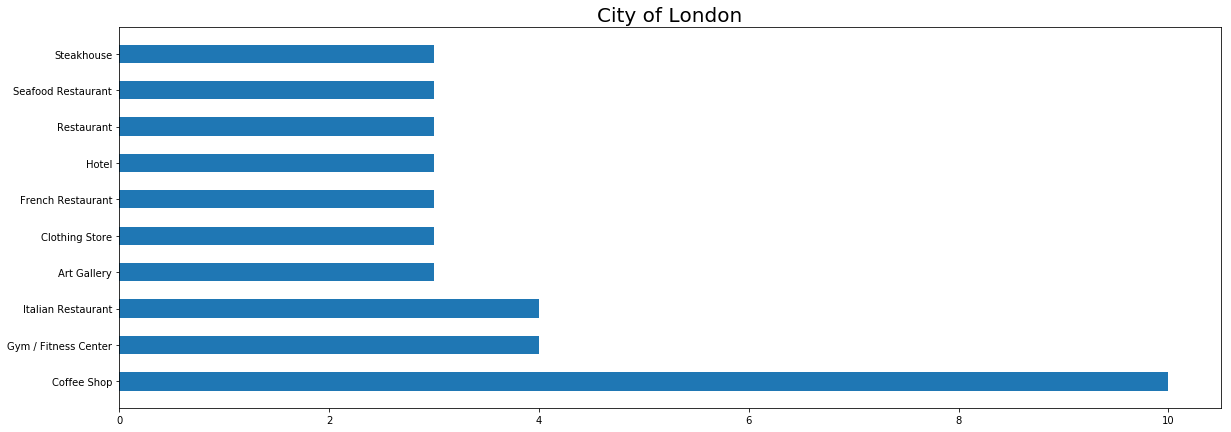

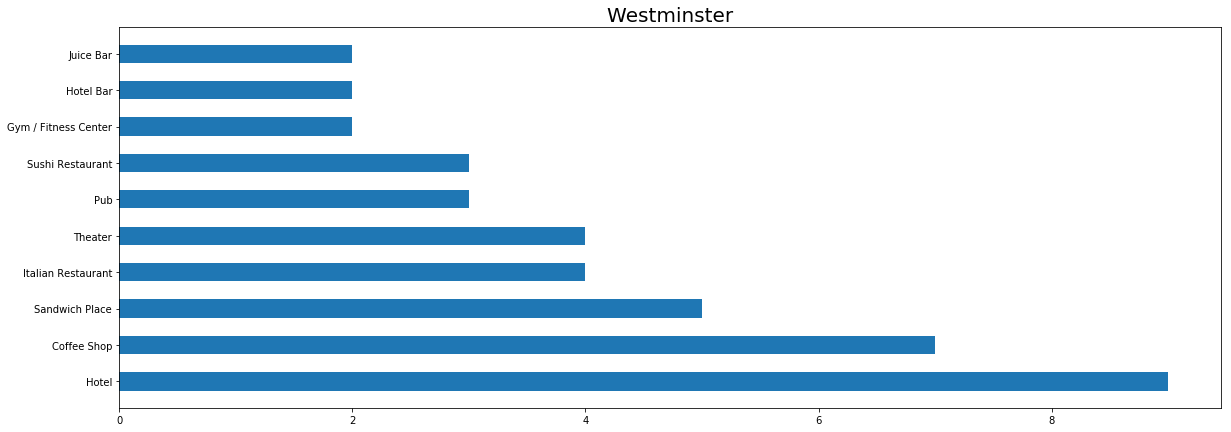

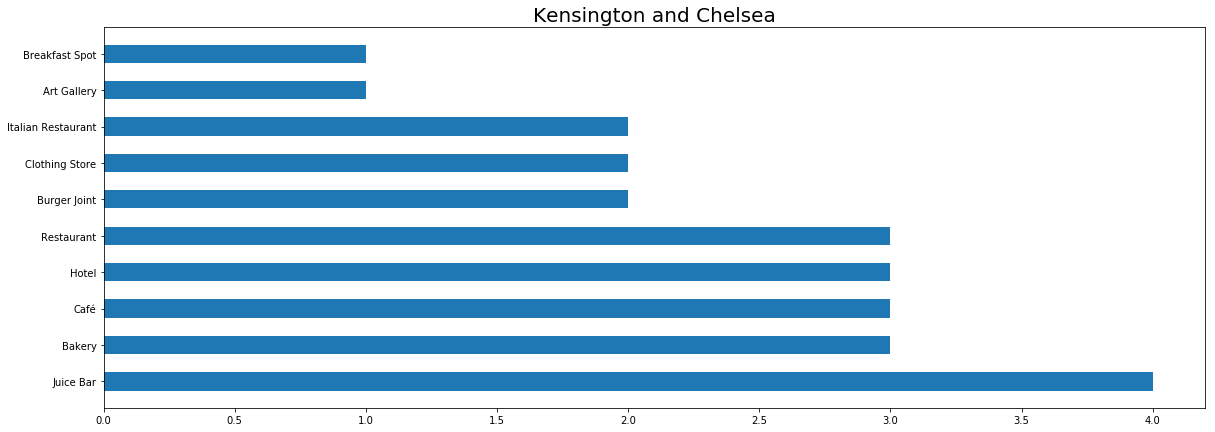

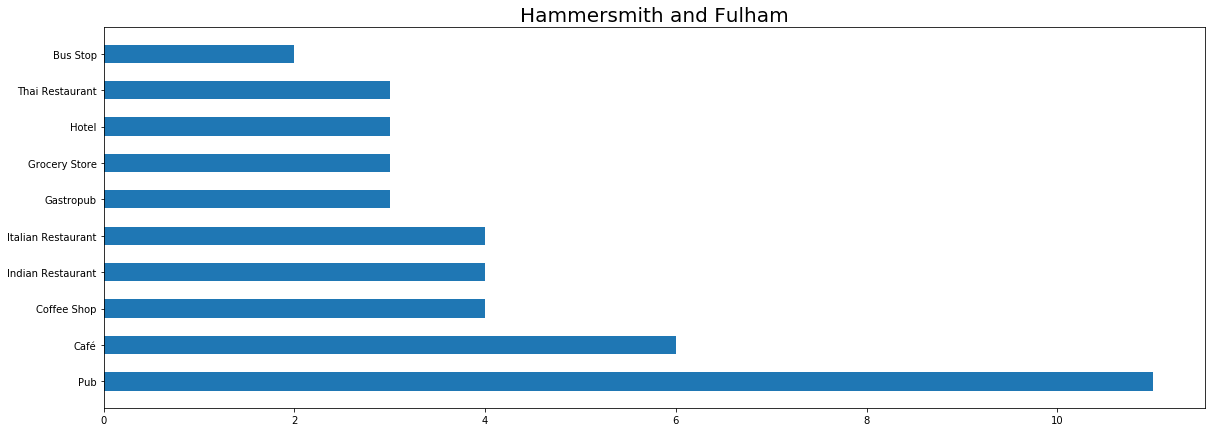

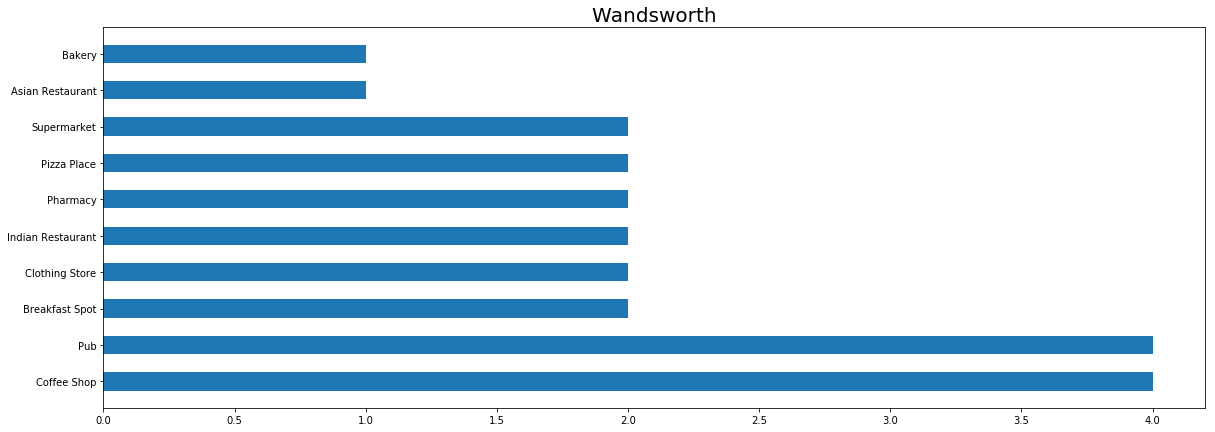

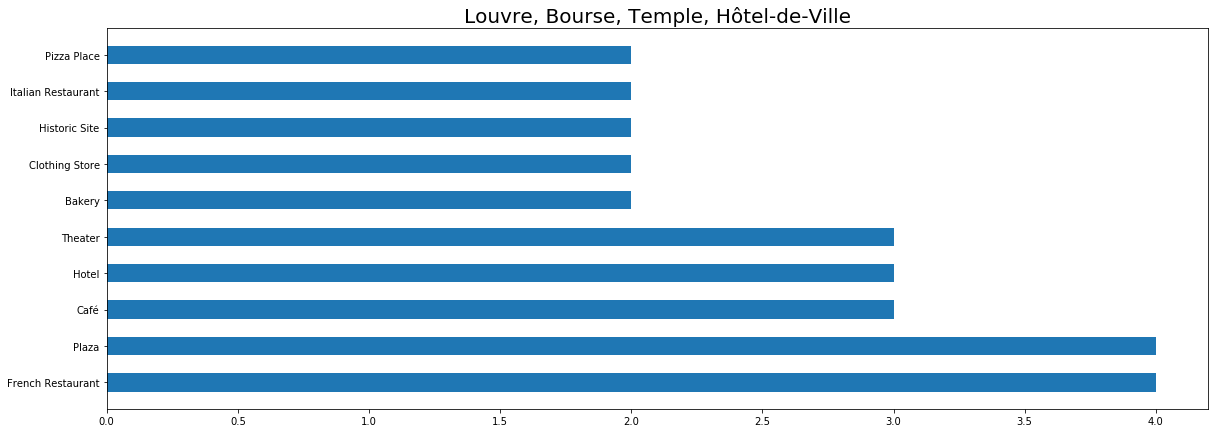

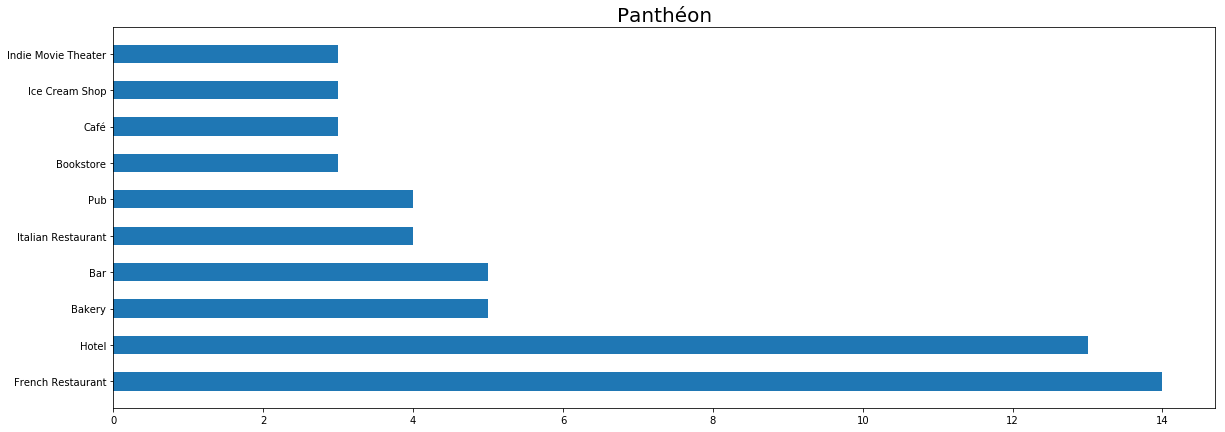

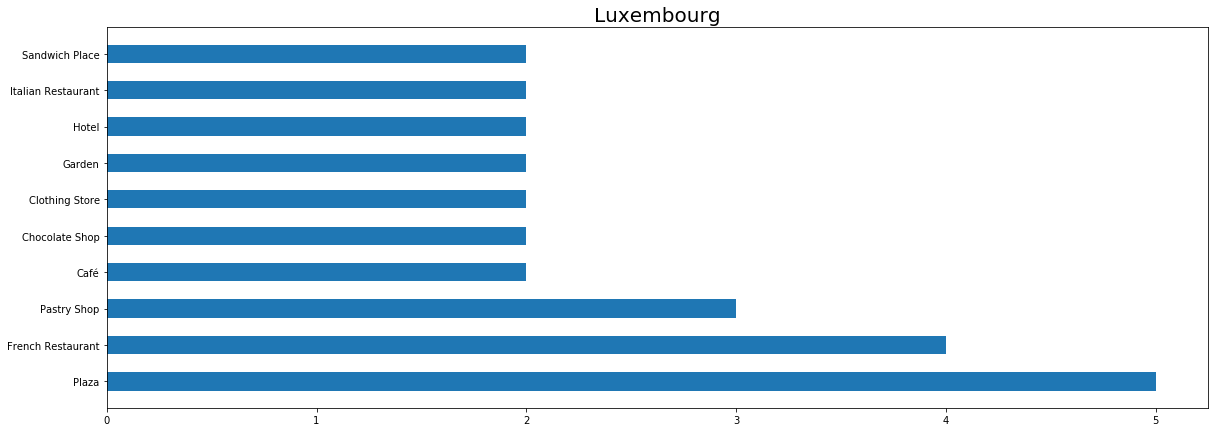

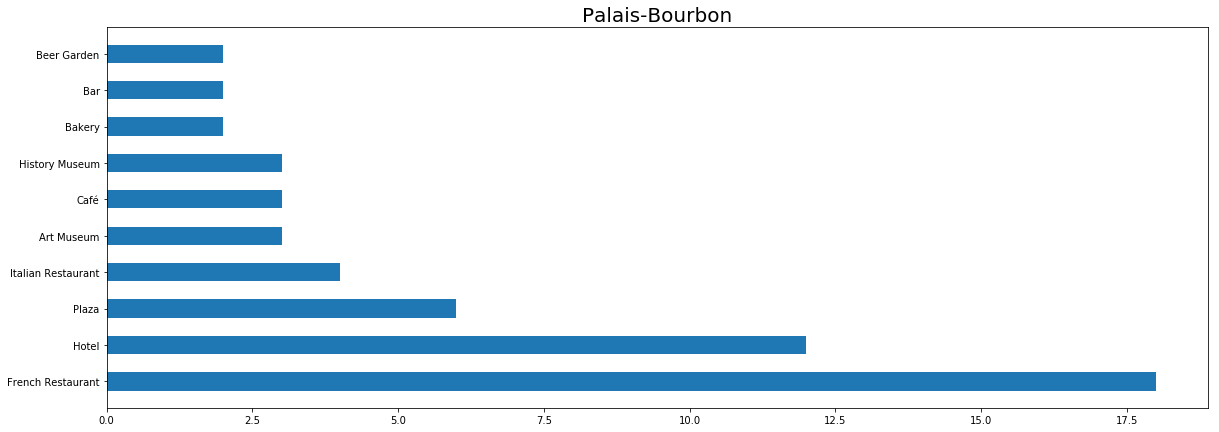

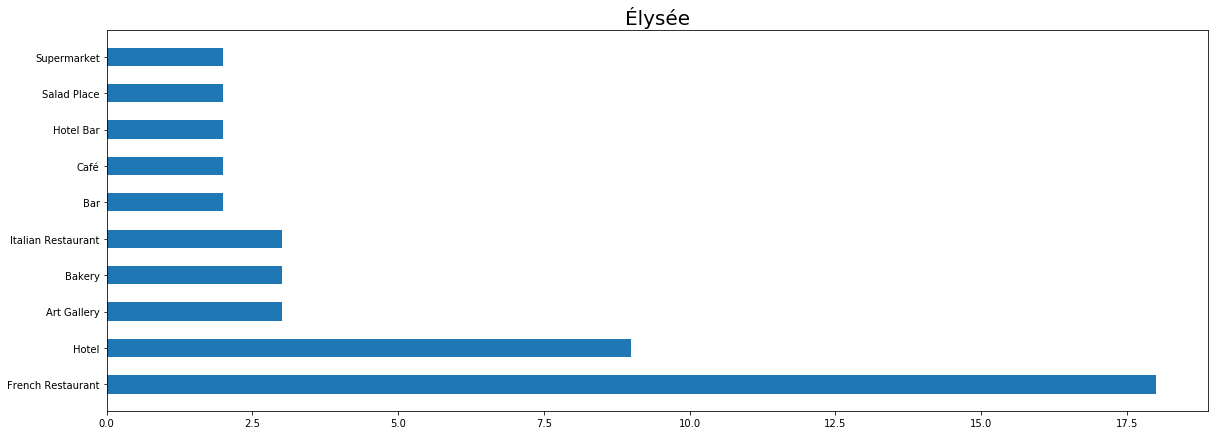

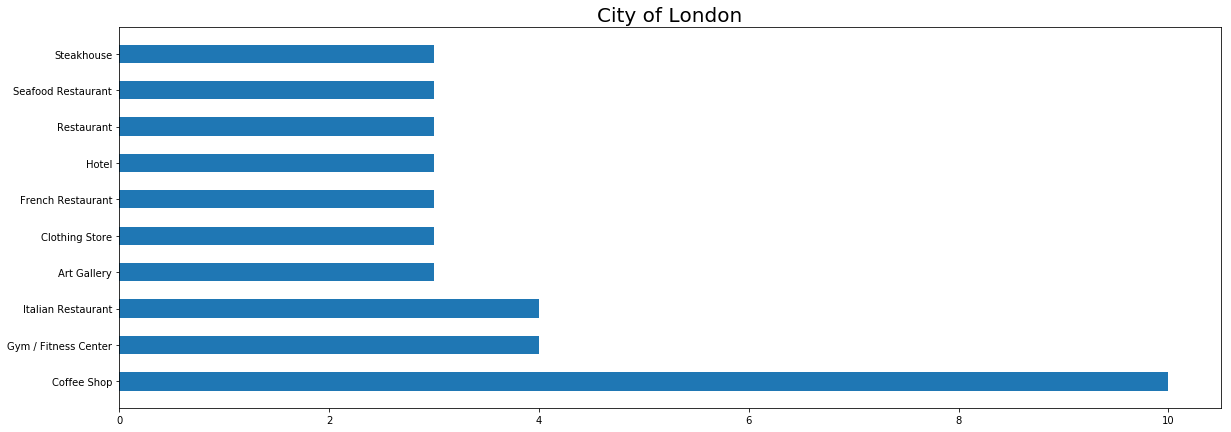

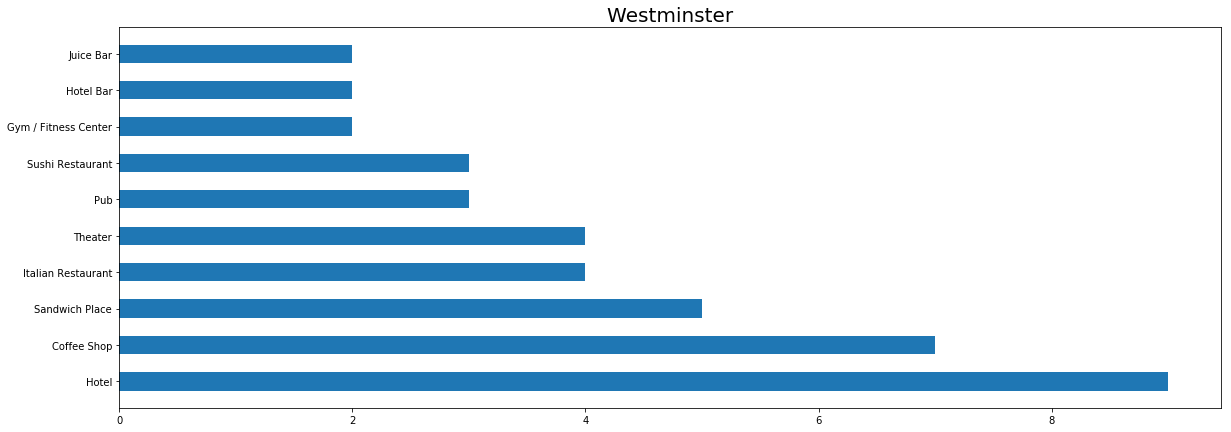

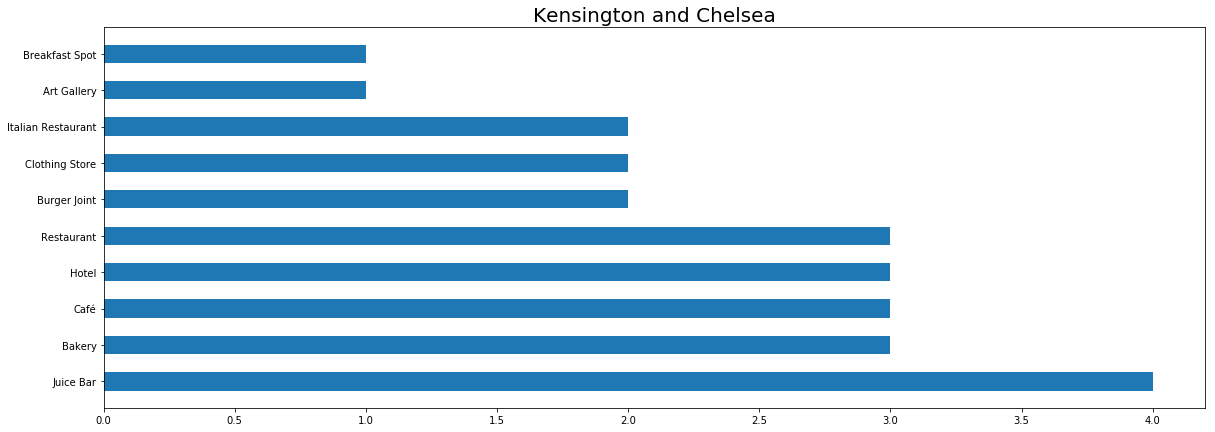

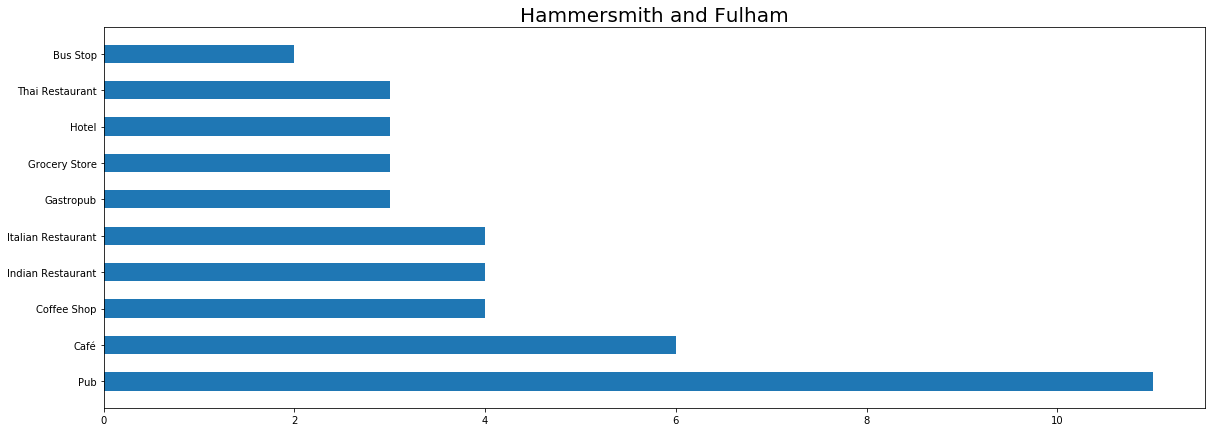

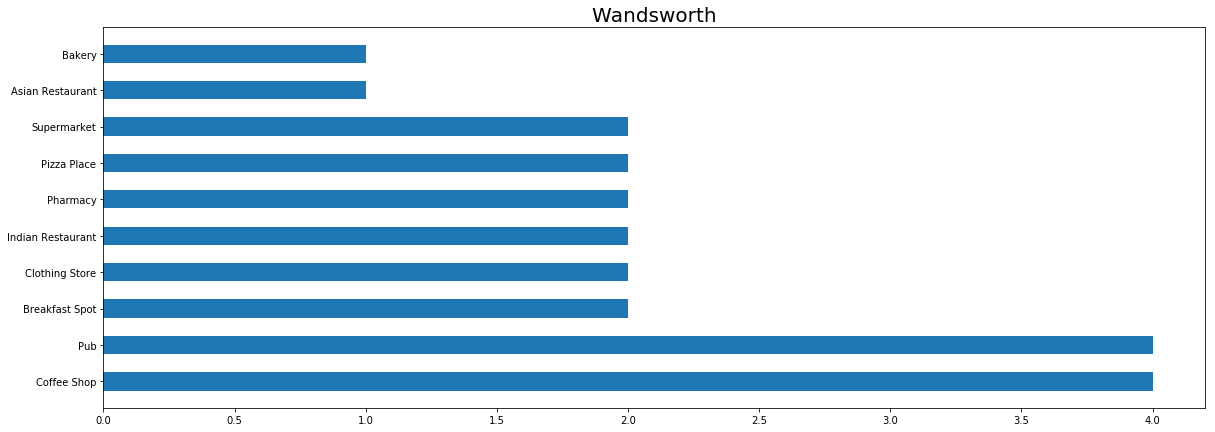

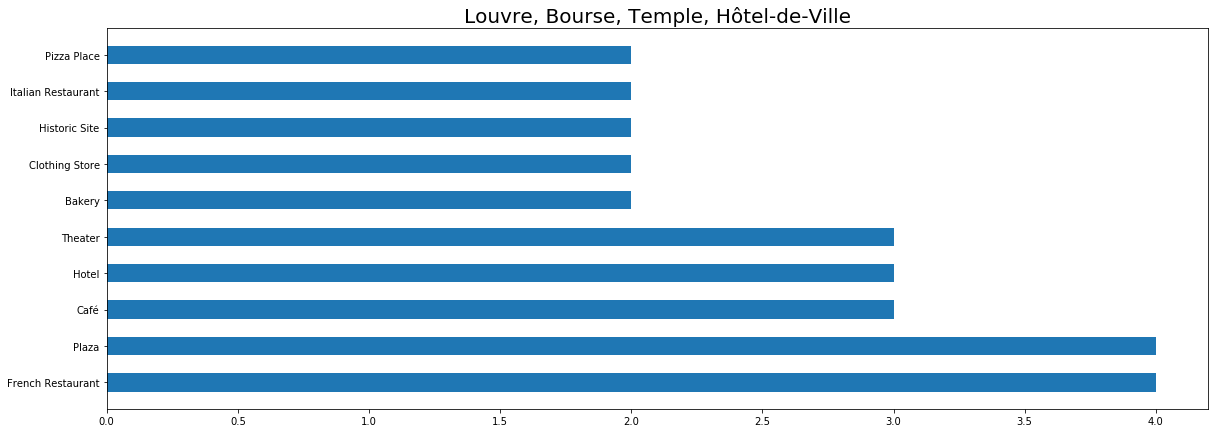

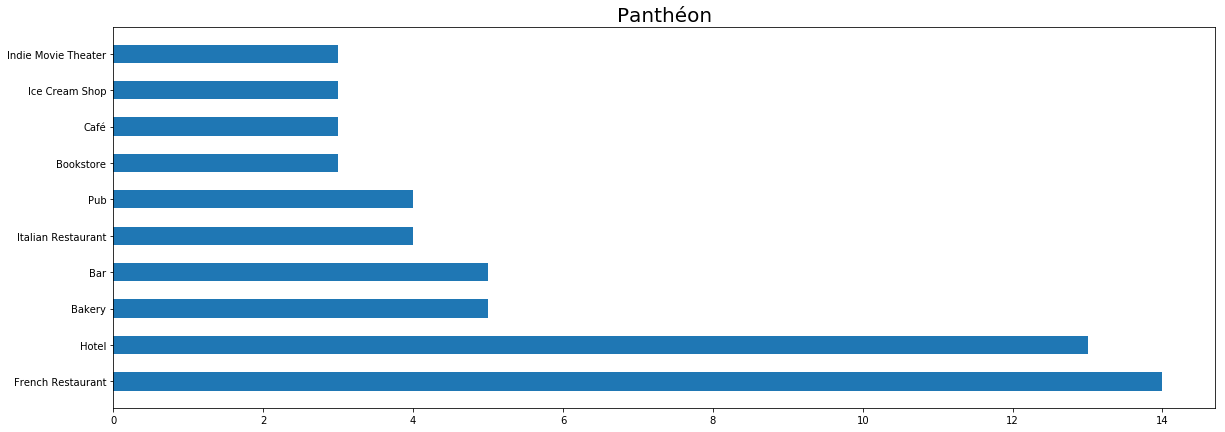

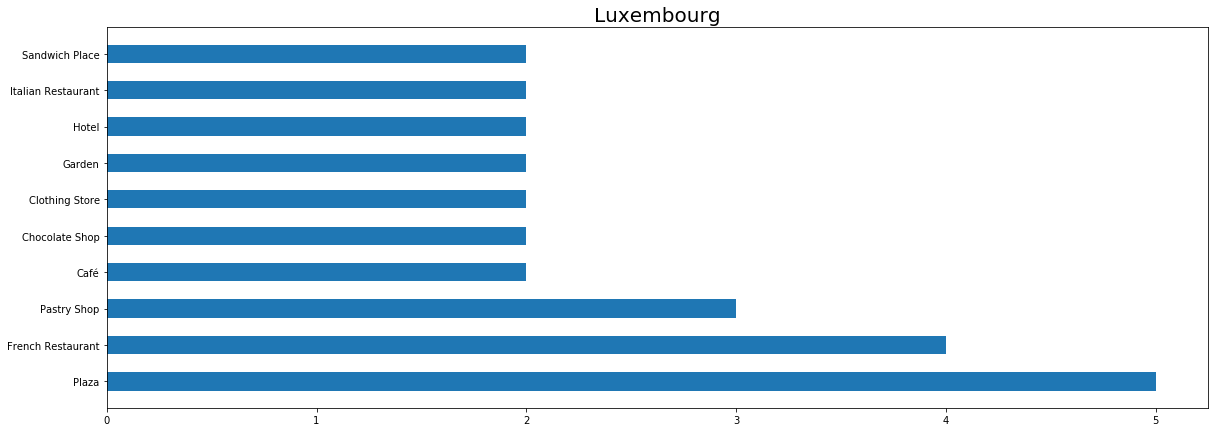

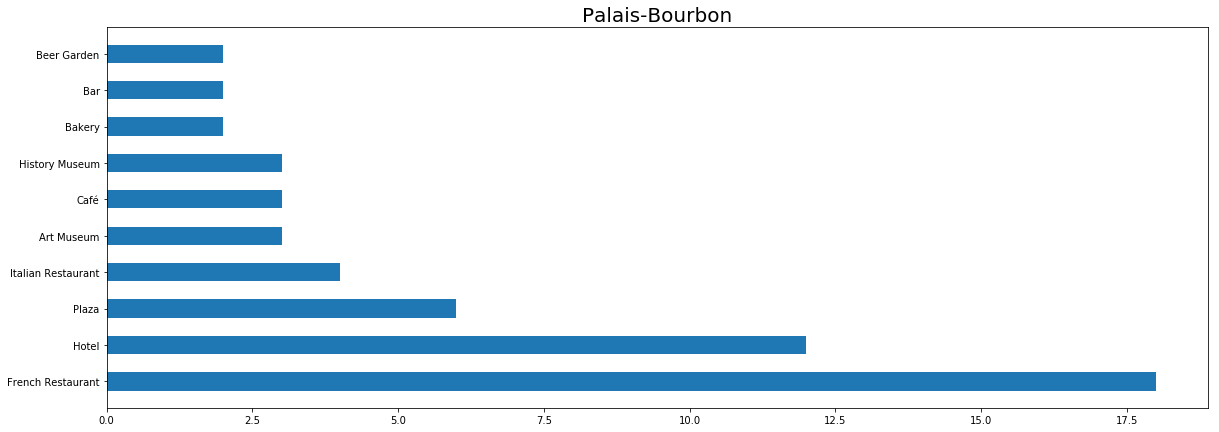

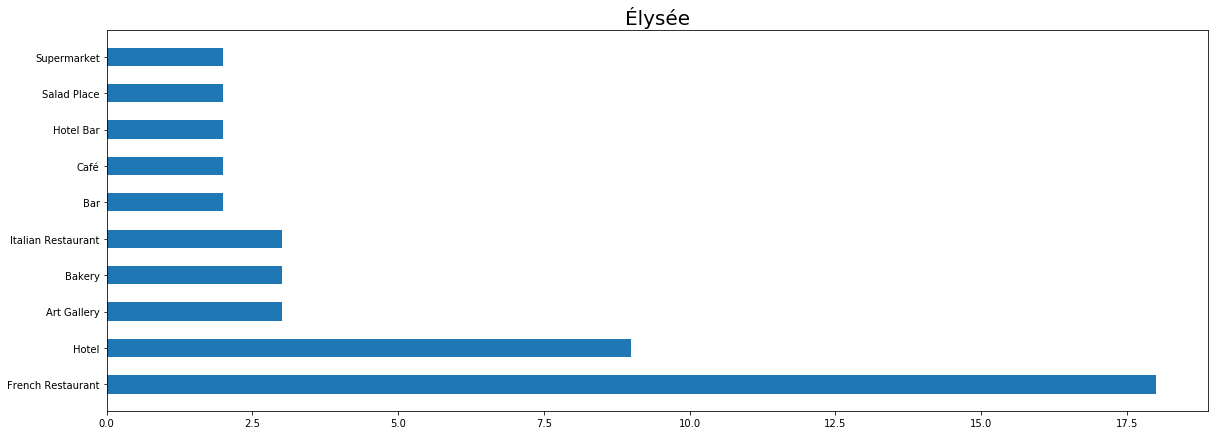

In [24]:
## Frequency bar chart for Boroughs from either city
nearbyvenues_count(London_venues, districtsL[0])
nearbyvenues_count(London_venues, districtsL[1])
nearbyvenues_count(London_venues, districtsL[2])
nearbyvenues_count(London_venues, districtsL[3])
nearbyvenues_count(London_venues, districtsL[4])
nearbyvenues_count(Paris_venues, districtsP[0])
nearbyvenues_count(Paris_venues, districtsP[1])
nearbyvenues_count(Paris_venues, districtsP[2])
nearbyvenues_count(Paris_venues, districtsP[3])
nearbyvenues_count(Paris_venues, districtsP[4])
plt.show()

In [26]:
#lets categorize the venues using foursquare API.


# one hot encoding
London_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['Borough'] = London_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.head()


London_grouped = London_onehot.groupby('Borough').mean().reset_index()




In [28]:
# one hot encoding for PARIS.
Paris_onehot = pd.get_dummies(Paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Paris_onehot['Borough'] = Paris_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [Paris_onehot.columns[-1]] + list(Paris_onehot.columns[:-1])
Paris_onehot = Paris_onehot[fixed_columns]

Paris_onehot.head()
Paris_grouped = Paris_onehot.groupby('Borough').mean().reset_index()



In [29]:


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]



In [30]:


num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe for London
Londonboroughs_venues_sorted = pd.DataFrame(columns=columns)
Londonboroughs_venues_sorted['Borough'] = London_grouped['Borough']

for ind in np.arange(London_grouped.shape[0]):
    Londonboroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

Londonboroughs_venues_sorted.head(10)



,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Pool,Gym / Fitness Center,Bus Station,Supermarket,Martial Arts School,Park,Golf Course,Dim Sum Restaurant,Event Space,Cycle Studio
1,Barnet,Café,Construction & Landscaping,Bus Stop,Yoga Studio,Event Space,Food Truck,Food Court,Flea Market,Fish Market,Fish & Chips Shop
2,Bexley,Pub,Clothing Store,Coffee Shop,Supermarket,Fast Food Restaurant,Pharmacy,Italian Restaurant,Furniture / Home Store,Men's Store,Department Store
3,Brent,Coffee Shop,Sporting Goods Shop,Clothing Store,Hotel,Bar,Sandwich Place,Grocery Store,Indian Restaurant,Italian Restaurant,Burger Joint
4,Bromley,Clothing Store,Coffee Shop,Pizza Place,Gym / Fitness Center,Burger Joint,Bar,Pub,Stationery Store,Café,Sandwich Place
5,Camden,Coffee Shop,Café,Hotel,Pub,Burger Joint,Deli / Bodega,Sandwich Place,Breakfast Spot,Italian Restaurant,Pizza Place
6,City of London,Coffee Shop,Gym / Fitness Center,Italian Restaurant,French Restaurant,Seafood Restaurant,Wine Bar,Hotel,Restaurant,Steakhouse,Clothing Store
7,Croydon,Pub,Coffee Shop,Portuguese Restaurant,Burger Joint,Burrito Place,Bookstore,Gaming Cafe,Breakfast Spot,Brewery,Spanish Restaurant
8,Ealing,Coffee Shop,Clothing Store,Pub,Park,Italian Restaurant,Bakery,Pizza Place,Gym / Fitness Center,Burger Joint,Vietnamese Restaurant
9,Enfield,Clothing Store,Coffee Shop,Supermarket,Pub,Optical Shop,Shopping Mall,Café,Pharmacy,Department Store,Bookstore


In [31]:
# create a new dataframe for Paris
Parisboroughs_venues_sorted = pd.DataFrame(columns=columns)
Parisboroughs_venues_sorted['Borough'] = Paris_grouped['Borough']

for ind in np.arange(Paris_grouped.shape[0]):
    Parisboroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Paris_grouped.iloc[ind, :], num_top_venues)

Parisboroughs_venues_sorted.head(10)

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Batignolles-Monceau,French Restaurant,Italian Restaurant,Bakery,Hotel,Bar,Pastry Shop,Diner,Restaurant,Playground,Gym / Fitness Center
1,Butte-Montmartre,Bar,French Restaurant,Restaurant,Theater,Café,Wine Bar,Pizza Place,Park,Italian Restaurant,Hotel
2,Buttes-Chaumont,French Restaurant,Supermarket,Pool,Bar,Hotel,Italian Restaurant,Metro Station,Beer Garden,Spa,Lebanese Restaurant
3,Entrepôt,French Restaurant,Bistro,Pizza Place,Café,Indian Restaurant,Bakery,Hotel,Restaurant,Seafood Restaurant,Bar
4,Gobelins,Hotel,Thai Restaurant,French Restaurant,Italian Restaurant,Bar,Vietnamese Restaurant,Indian Restaurant,Asian Restaurant,Bakery,Movie Theater
5,"Louvre, Bourse, Temple, Hôtel-de-Ville",Plaza,French Restaurant,Hotel,Theater,Café,Bakery,Pizza Place,Clothing Store,Tea Room,Italian Restaurant
6,Luxembourg,Plaza,French Restaurant,Pastry Shop,Chocolate Shop,Clothing Store,Seafood Restaurant,Hotel,Tailor Shop,Tea Room,Italian Restaurant
7,Ménilmontant,Bar,French Restaurant,Japanese Restaurant,Bistro,Bakery,Café,Plaza,Park,Italian Restaurant,Restaurant
8,Observatoire,French Restaurant,Bakery,Italian Restaurant,Bar,Hotel,Sushi Restaurant,Plaza,Restaurant,Bistro,Southwestern French Restaurant
9,Opéra,French Restaurant,Hotel,Bistro,Japanese Restaurant,Salad Place,Wine Bar,Bar,Coffee Shop,Cocktail Bar,Bakery


# Clustering analysis ,In this case k-means cluserting ,Based on elbow method k-value will be assigned in the next cell.

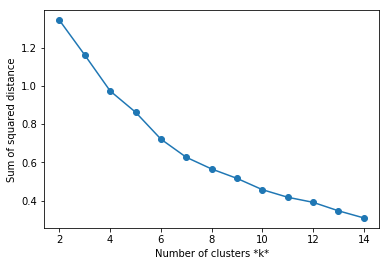

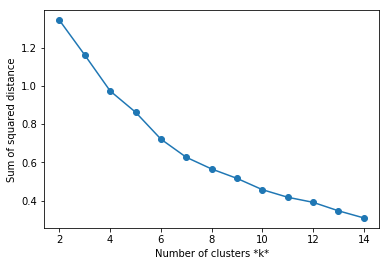

In [33]:
London_grouped_clustering = London_grouped.drop('Borough', 1)

## Finding the optimal K using elbow method
from sklearn.metrics import silhouette_score

sse = []
sscr =[]
list_k = list(range(2, 15))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0).fit(London_grouped_clustering)
    sse.append(km.inertia_)
    sscr.append(silhouette_score(London_grouped_clustering, km.labels_, metric='euclidean'))

plt.figure(figsize=(6, 4))
plt.plot(list_k, sse, '-o',label='sse')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.show()

In [34]:


# Clustering London Boroughs first
# set number of clusters
kclustersL = 6

# run k-means clustering
kmeansL = KMeans(n_clusters=kclustersL, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeansL.labels_[0:10])

# add clustering labels
Londonboroughs_venues_sorted.insert(0, 'Cluster Labels', kmeansL.labels_)

London_merged = tableL

# merge London_grouped with London_data to add latitude/longitude for each neighborhood
London_merged = London_merged.join(Londonboroughs_venues_sorted.set_index('Borough'), on='Borough')

London_merged.head() # check the last columns!



[0 3 1 1 1 1 1 1 1 1]


,District Number,Area,Borough,Population,Population (2019 est)[1],Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,1.12,City of London,9721,0,51.5155,-0.0922,1,Coffee Shop,Gym / Fitness Center,Italian Restaurant,French Restaurant,Seafood Restaurant,Wine Bar,Hotel,Restaurant,Steakhouse,Clothing Store
1,2,8.29,Westminster,261317,0,51.4973,-0.1372,1,Hotel,Coffee Shop,Sandwich Place,Italian Restaurant,Theater,Sushi Restaurant,Pub,Gym / Fitness Center,Hotel Bar,Sporting Goods Shop
2,3,4.68,Kensington and Chelsea,156129,0,51.5020,-0.1947,1,Juice Bar,Hotel,Café,Bakery,Restaurant,Burger Joint,Clothing Store,Italian Restaurant,French Restaurant,Mexican Restaurant
3,4,6.33,Hammersmith and Fulham,185143,0,51.4927,-0.2339,1,Pub,Café,Coffee Shop,Italian Restaurant,Indian Restaurant,Hotel,Grocery Store,Thai Restaurant,Gastropub,Bus Stop
4,5,13.23,Wandsworth,329677,0,51.4567,-0.1910,1,Pub,Coffee Shop,Pharmacy,Supermarket,Clothing Store,Breakfast Spot,Pizza Place,Indian Restaurant,Restaurant,Chaat Place


In [36]:


addressL = 'London, United Kingdom'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(addressL)
latitude_London = location.latitude
longitude_London = location.longitude
print('The geograpical coordinates of London city are {}, {}.'.format(latitude_London, longitude_London))



The geograpical coordinates of London city are 51.5073219, -0.1276474.


In [37]:
# create map
map_clustersL = folium.Map(location=[latitude_London, longitude_London], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclustersL)
ys = [i + x + (i*x)**2 for i in range(kclustersL)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, pop in zip(London_merged['Latitude'], London_merged['Longitude'], London_merged['Borough'], London_merged['Cluster Labels'], London_merged['Population']/(London_merged['Area']*2.59)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=pop/1000,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clustersL)
       
map_clustersL

In [38]:
addressP = 'Paris, France'

geolocator = Nominatim(user_agent="tr_explorer")
locationP = geolocator.geocode(addressP)
latitude_Paris = locationP.latitude
longitude_Paris = locationP.longitude
print('The geograpical coordinates of Paris city are {}, {}.'.format(latitude_Paris, longitude_Paris))

The geograpical coordinates of Paris city are 48.8566969, 2.3514616.


In [39]:
London_merged.loc[London_merged['Cluster Labels'] == 0, London_merged.columns[[1] + list(range(5, London_merged.shape[1]))]]

,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,13.93,51.5607,0.1557,0,Pool,Gym / Fitness Center,Bus Station,Supermarket,Martial Arts School,Park,Golf Course,Dim Sum Restaurant,Event Space,Cycle Studio


In [40]:

London_merged.loc[London_merged['Cluster Labels'] == 1, London_merged.columns[[1] + list(range(5, London_merged.shape[1]))]]


,Area,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1.12,51.5155,-0.0922,1,Coffee Shop,Gym / Fitness Center,Italian Restaurant,French Restaurant,Seafood Restaurant,Wine Bar,Hotel,Restaurant,Steakhouse,Clothing Store
1,8.29,51.4973,-0.1372,1,Hotel,Coffee Shop,Sandwich Place,Italian Restaurant,Theater,Sushi Restaurant,Pub,Gym / Fitness Center,Hotel Bar,Sporting Goods Shop
2,4.68,51.5020,-0.1947,1,Juice Bar,Hotel,Café,Bakery,Restaurant,Burger Joint,Clothing Store,Italian Restaurant,French Restaurant,Mexican Restaurant
3,6.33,51.4927,-0.2339,1,Pub,Café,Coffee Shop,Italian Restaurant,Indian Restaurant,Hotel,Grocery Store,Thai Restaurant,Gastropub,Bus Stop
4,13.23,51.4567,-0.1910,1,Pub,Coffee Shop,Pharmacy,Supermarket,Clothing Store,Breakfast Spot,Pizza Place,Indian Restaurant,Restaurant,Chaat Place
5,10.36,51.4607,-0.1163,1,Caribbean Restaurant,Pub,Coffee Shop,Market,Beer Bar,Gym / Fitness Center,Pizza Place,Tapas Restaurant,Cocktail Bar,Grocery Store
6,11.14,51.5035,-0.0804,1,Coffee Shop,Pub,Bar,Scenic Lookout,Cocktail Bar,Pizza Place,French Restaurant,Italian Restaurant,Indian Restaurant,Hotel
7,7.63,51.5099,-0.0059,1,Gym / Fitness Center,Hotel,Italian Restaurant,Sandwich Place,Coffee Shop,Fried Chicken Joint,Café,Steakhouse,Outdoor Sculpture,Chinese Restaurant
8,7.36,51.5450,-0.0553,1,Pub,Coffee Shop,Brewery,Bakery,Cocktail Bar,Modern European Restaurant,Vietnamese Restaurant,Clothing Store,Organic Grocery,Café
9,5.74,51.5416,-0.1022,1,Pub,Bakery,Park,Boutique,Ice Cream Shop,Music Venue,Theater,Burger Joint,Yoga Studio,Mediterranean Restaurant


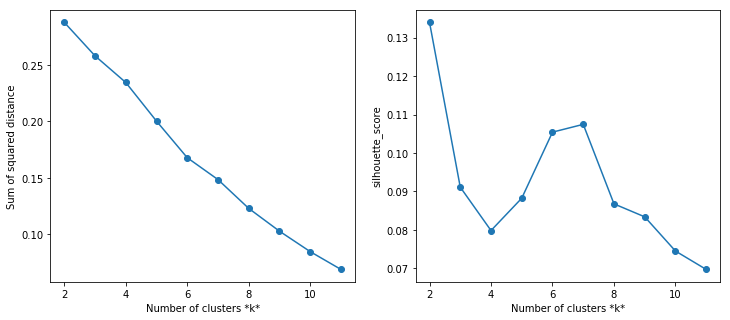

In [41]:
Paris_grouped_clustering = Paris_grouped.drop('Borough', 1)

## Finding the optimal K using elbow and silhouette score method
sseP = []
sscrP =[]
list_kP = list(range(2, 12))

for k in list_kP:
    kmP = KMeans(n_clusters=k, random_state=0).fit(Paris_grouped_clustering)
    sseP.append(kmP.inertia_)
    sscrP.append(silhouette_score(Paris_grouped_clustering, kmP.labels_, metric='euclidean'))

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(list_kP, sseP, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.subplot(122)
plt.plot(list_kP, sscrP, '-o',label='silhouette_score')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('silhouette_score');
plt.show()

In [42]:
# Clustering Paris Boroughs first
# set number of clusters
kclustersP = 2

# run k-means clustering
kmeansP = KMeans(n_clusters=kclustersP, random_state=0).fit(Paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeansP.labels_[0:10])

# add clustering labels
Parisboroughs_venues_sorted.insert(0, 'Cluster Labels', kmeansP.labels_)

Paris_merged = tableP

# merge Paris_grouped with Paris_data to add latitude/longitude for each neighborhood
Paris_merged = Paris_merged.join(Parisboroughs_venues_sorted.set_index('Borough'), on='Borough')

Paris_merged.head() # check the last columns!

[1 0 1 0 0 0 0 0 1 0]


,Area,District Number,Borough,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5.59,1,"Louvre, Bourse, Temple, Hôtel-de-Ville",100196,48.860000,2.341110,0,Plaza,French Restaurant,Hotel,Theater,Café,Bakery,Pizza Place,Clothing Store,Tea Room,Italian Restaurant
1,2.541,5,Panthéon,59631,48.847220,2.344440,1,French Restaurant,Hotel,Bar,Bakery,Italian Restaurant,Pub,Plaza,Bookstore,Café,Indie Movie Theater
2,2.154,6,Luxembourg,41976,48.850531,2.332233,0,Plaza,French Restaurant,Pastry Shop,Chocolate Shop,Clothing Store,Seafood Restaurant,Hotel,Tailor Shop,Tea Room,Italian Restaurant
3,4.088,7,Palais-Bourbon,52193,48.859170,2.312780,1,French Restaurant,Hotel,Plaza,Italian Restaurant,History Museum,Café,Art Museum,Bakery,Restaurant,Beer Garden
4,3.881,8,Élysée,37368,48.874170,2.311110,1,French Restaurant,Hotel,Art Gallery,Italian Restaurant,Bakery,Bar,Hotel Bar,Salad Place,Café,Supermarket


In [43]:
# create map
map_clustersP = folium.Map(location=[latitude_Paris, longitude_Paris], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclustersP)
ys = [i + x + (i*x)**2 for i in range(kclustersP)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, pop in zip(Paris_merged['Latitude'], Paris_merged['Longitude'], Paris_merged['Borough'], Paris_merged['Cluster Labels'],Paris_merged['Population']/(Paris_merged['Area'])):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=pop/2000,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clustersP)
       
map_clustersP

In [44]:
Paris_merged.loc[Paris_merged['Cluster Labels'] == 1, Paris_merged.columns[[1] + list(range(5, Paris_merged.shape[1]))]]

,District Number,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,5,2.344440,1,French Restaurant,Hotel,Bar,Bakery,Italian Restaurant,Pub,Plaza,Bookstore,Café,Indie Movie Theater
3,7,2.312780,1,French Restaurant,Hotel,Plaza,Italian Restaurant,History Museum,Café,Art Museum,Bakery,Restaurant,Beer Garden
4,8,2.311110,1,French Restaurant,Hotel,Art Gallery,Italian Restaurant,Bakery,Bar,Hotel Bar,Salad Place,Café,Supermarket
10,14,2.326889,1,French Restaurant,Bakery,Italian Restaurant,Bar,Hotel,Sushi Restaurant,Plaza,Restaurant,Bistro,Southwestern French Restaurant
11,15,2.300292,1,French Restaurant,Italian Restaurant,Hotel,Supermarket,Coffee Shop,Thai Restaurant,Park,Japanese Restaurant,Lebanese Restaurant,Bar
12,16,2.276489,1,Bakery,French Restaurant,Hotel,Restaurant,Café,Garden,Supermarket,Chinese Restaurant,Diner,Japanese Restaurant
13,17,2.307839,1,French Restaurant,Italian Restaurant,Bakery,Hotel,Bar,Pastry Shop,Diner,Restaurant,Playground,Gym / Fitness Center
15,19,2.381822,1,French Restaurant,Supermarket,Pool,Bar,Hotel,Italian Restaurant,Metro Station,Beer Garden,Spa,Lebanese Restaurant
